> Note: Materi ini merupakan materi supplemental, tidak bersifat wajib. Namun akan mendukung kalian menjadi seorang _AI engineer_ yang handal.

# Model Deployment

Model deployment is a crucial step in the machine learning development where the trained model is made accessible for users and integrated into applications.

It involves saving the model after training and providing a means for users, frontend (FE), and/or backend (BE) systems to access predictions.
In this notebook, we'll cover various aspects of model deployment, including different deployment options and strategies for optimizing models for deployment on CPU deployment

## Various type of Model Deployment
Deploying a machine learning model means making it accessible to users and other systems. This involves creating an interface through which users can provide input data and receive predictions. Here are some common deployment options:

*  API (Application Programming Interface): An API serves as a bridge between your model and external applications. Flask and FastAPI are popular frameworks for building APIs in Python.

*  Mobile Apps: For mobile deployment, you can use frameworks like **PyTorch Mobile**, **TensorFlow Lite (TFLite)**  **CoreML**. These frameworks allow you to integrate your model into Android or iOS applications, enabling real-time inference on mobile devices.

*  PC Apps: When deploying models in desktop applications, the choice of technology depends on the application platform. For Python-based apps, you can use libraries like Tkinter or PyQt. For cross-platform apps, consider using Flutter for a consistent user experience across different operating systems.

*  Web Apps: You also can deploy your model using Tensorflow JS to a web app without having to rely on a backend server, With Tensorflow JS you can use both CPU and GPU from user for accelerating the model deployment process. Keep in mind that if we deploy our model to a web app, we'll basically use end-user computing power to process our model, so consider only using this method on simple and small model.

- inference time -->

# Model Optimization for Deployment

In this notebook, we'll focus on optimizing models for deployment on CPU environments by quantize model using ONNX (Open Neural Network Exchange) framework

But before we begin, Why using ONNX instead of Tensofrlow or Pytorch directly?

1. **ONNX is faster for inference** using ONNX Runtime to do inference, resulted slightly faster inference time than pytorch in some cases in fp32 weights, but more faster in fp16 weights [example case](https://cloudblogs.microsoft.com/opensource/2022/04/19/scaling-up-pytorch-inference-serving-billions-of-daily-nlp-inferences-with-onnx-runtime/) (will discuss more in the next section about fp32, fp16 and int8 later)

2. **Framework Interoperability**: ONNX allows you to train a model in one language and then export and run it in another. This can be very advantageous for teams that use different frameworks or if you want to build a model in one language and then deploy it in another.

3. **Portability and Deployment Ease**: ONNX can be used for running models on various platforms including cloud, edge devices, or on-premises servers. This way, you can avoid rewriting and retraining models for all these settings.

4. **Broad Support**: Several well-known organizations and software vendors have thrown their support behind ONNX, ensuring that it would not be abandoned anytime soon. These include Microsoft, Facebook, Amazon, Intel, AMD, NVIDIA, IBM, and more.


In [ ]:
tensorflow, pytorch, sklearn, xgboost, lightgbm, catboost
# optimize Inference

In [ ]:
tensorflow --> convert --> onnx

Install depedencies

In [ ]:
!pip install torch torchvision torchaudio --index-url https://download.pytorch.org/whl/cpu
!pip install transformers
!pip install optimum["onnxruntime"]

# Accelerate inference using model quantization

In [ ]:
float 32, int 32 int 16 --> int8/flowt 8

# biaya akan tinggi, karna resource yg dibutuhin tinggi
# resource turun > cost turun > bisnis untung

## Create Performance Baseline

Before optimizing a model, it's important to establish a baseline for comparison so later we can compare it and see if our optimization has any effect. In this case, we'll measure
*  Time taken to generate predictions on the CPU using the original model.
*  Model performance, in this case is accuracy

Here we are using Fine-tuned model (model from transfer learning) as our baseline model
The dataset used for this notebook is [indonlu-smsa](https://huggingface.co/datasets/indonlp/indonlu), which used for sentiment analysis

In [ ]:
from transformers import AutoTokenizer, AutoModelForSequenceClassification
from transformers import pipeline
import time

tokenizer = AutoTokenizer.from_pretrained("ayameRushia/roberta-base-indonesian-1.5G-sentiment-analysis-smsa")
model = AutoModelForSequenceClassification.from_pretrained("ayameRushia/roberta-base-indonesian-1.5G-sentiment-analysis-smsa")

cls = pipeline("text-classification", model=model, tokenizer=tokenizer)

Download Dataset for Testing from Huggingface dataset, in here we will use dataset from [indonlu-smsa](https://huggingface.co/datasets/indonlp/indonlu)

In [ ]:
from datasets import load_dataset

dataset = load_dataset("indonlp/indonlu", "smsa")

# establish testing input and label
testing_input = dataset["test"]["text"]
testing_label = dataset["test"]["label"]

In [ ]:
# sneak peek to testing data

print(testing_input[:5])
print(testing_label[:5])

['meski masa kampanye sudah selesai , bukan berati habis pula upaya mengerek tingkat kedipilihan elektabilitas .', 'tidak enak', 'restoran ini menawarkan makanan sunda . kami memesan ayam goreng , kangkung , sayur asam , ikan gurame goreng , ikan bakar , nasi goreng , karedok , tahu tempe , nasi putih , nasi merah etc minuman yang mereka tawarkan juga cukup variatif . rasa makanan enak dan harga murah . kami 9 dewasa dan 5 anak kecil , hanya menghabiskan 800,000', 'lokasi di alun alun masakan padang ini cukup terkenal dengan kepala ikan kakap gule , biasa saya pesan nasi bungkus padang berisikan rendang , ayam pop dan perkedel . porsi banyak dan mengenyangkan', 'betapa bejad kader gerindra yang anggota dprd mencabuli anak smp , rakyat harus cerdas partai mana yang harus di tengelamkan di 2019']
[1, 2, 0, 0, 2]


In [ ]:
dataset['train']

AttributeError: ignored

### Measure Accuracy and time taken to inference all testing data

In [ ]:
import evaluate

# We use the evaluate function to evaluate our model on the testing data, and the metrisc we want to use is accuracy
precision_metric = evaluate.load("accuracy")

Measure inference time of the baseline model

In [ ]:
t1 = time.time()
result = cls(testing_input)
result = [model.config.label2id[x["label"]] for x in result]
t2 = time.time()

inference_time_vanilla = t2-t1
avg_time_vanilla = inference_time_vanilla/len(result)

print(f'Total inference time for vanilla model is {inference_time_vanilla:.3f} s')
print(f'average inference time for vanilla model is {avg_time_vanilla:.3f} s')

Total inference time for vanilla model is 86.715 s
average inference time for vanilla model is 0.173 s


Measure accuracy of the baseline model

In [ ]:
results_vanilla = precision_metric.compute(
    references=testing_label, predictions=result)

print(f'Accuracy of the vanilla model on testing dataset {results_vanilla["accuracy"]*100:.3f}%')

Accuracy of the vanilla model on testing dataset 88.400%


## Now lets try optimize our model

### Quantization Model

The optimization process taken in this notebook is called quantization

Quantization is a technique to reduce the computational and memory costs of running inference by representing the **weights** and **activations** with low-precision data types like 8-bit integer (int8) instead of the usual 32-bit floating point (float32).

Reducing the number of bits means the resulting model requires less memory storage, consumes less energy (in theory), and operations like matrix multiplication can be performed much faster with integer arithmetic. It also allows to run models on embedded devices, which sometimes only support integer data types.

While the quantization process substantially reduces the computational and memory load by using low-precision data types like 8-bit integers for representing weights and activations, it's crucial to be aware of its impact on model accuracy. The inherent reduction in precision due to quantization can potentially degrade model performance, as it relies on a degree of approximation. This may not be acceptable for use-cases necessitating high precision.

There are two ways of doing quantization, we won't be explaining the concept in detail, but rather the difference in their output for both methods :

1. Quantization parameters can be computed on a **per-tensor** basis, faster but slightly less accurate and requires less memory.

2. Quantization parameters can be computed on a **per-channel** basis, better accuracy, it requires more memory and slower

#### Quantization Calibration

Calibration is the step during quantization where the float32 ranges are computed. For **weight**s it is quite easy since the actual range is known at quantization-time. But it is less clear for
**activations**, and different approaches exist:

1. Post training dynamic quantization: the range for each activation is computed on the fly at runtime, This is the simplest approach but slower when compared to static quantization

2. Post training static quantization: the range for each activation is computed in advance at quantization-time, typically by passing representative data through the model and recording the activation values. Thus, make the inference time faster

#### In this notebook we will use per-tensor quantization with post training dynamic quantization
Without further ado, let's quantize our model!

First we export our model to onnx from pytorch

In [ ]:
from optimum.onnxruntime import ORTModelForSequenceClassification, ORTQuantizer
from optimum.onnxruntime.configuration import AutoQuantizationConfig

# Load the model from the hub and export it to the ONNX format
model = ORTModelForSequenceClassification.from_pretrained(
    "ayameRushia/roberta-base-indonesian-1.5G-sentiment-analysis-smsa", export=True)

Framework not specified. Using pt to export to ONNX.
Using the export variant default. Available variants are:
	- default: The default ONNX variant.
Using framework PyTorch: 2.0.1+cu118
Overriding 1 configuration item(s)
	- use_cache -> False


============= Diagnostic Run torch.onnx.export version 2.0.1+cu118 =============
verbose: False, log level: Level.ERROR
======================= 0 NONE 0 NOTE 0 WARNING 0 ERROR ========================




#### After exporting the model to onnx we will use ORTQuantizer to quantize our model and add quantization config.

##### Load quantizer for our pretrained/fine-tuned model
##### Add quantization config based on your CPU type:
      - AVX512 (general user CPU, intel and amd)
      - ARM (mobile CPU, apple silicon, embedded device such as Jetson Nano from nvidia or raspberry pi)
      - AVX2 (older CPU, intel and amd)


##### In **Google Colab** we assume that we use AVX512 CPU, so we will use quantization config for AVX512
##### Define quantization type and calibration type, which is **dynamic quantization** and **per-tensor quantization**




In [ ]:
quantizer = ORTQuantizer.from_pretrained(model)
dqconfig = AutoQuantizationConfig.avx512_vnni(is_static=False, per_channel=False)

Then, quantize the model using defined quantizer and quantization config

In [ ]:
save_dir = "model/model_onnx"

model_quantized_path = quantizer.quantize(
    save_dir=save_dir,
    quantization_config=dqconfig,
)

Creating dynamic quantizer: QOperator (mode: IntegerOps, schema: u8/s8, channel-wise: False)
Quantizing model...
Saving quantized model at: model/model_onnx (external data format: False)
Configuration saved in model/model_onnx/ort_config.json


In hypothesis, after quantizing our model from fp32 to int8, the model size will be reduced and the inference time will be faster
Then, lets first compute the size of the model before and after quantization

In [ ]:
import os

size_model_q = os.path.getsize("/content/model/model_onnx/model_quantized.onnx")/1024/1024  # divide by 1024 because the result is in bytes, divide by 1024 again to get the result in MB
print(f"Size of the quantized model is {size_model_q:.3f} MB")

Size of the quantized model is 120.984 MB


The result is pretty good, we reduce the model size from 518 MB (vanilla pytorch) to only 120.98 MB (quantized model)

Now, lets try to measure the inference time of the quantized model

Create pipeline using quantized model from optimum (also library from huggingface)

In [ ]:
from optimum.pipelines import pipeline

model = ORTModelForSequenceClassification.from_pretrained("model/model_onnx")
onnx_clx = pipeline("text-classification", model=model)

In [ ]:
t1_onnx = time.time()
result_q = onnx_clx(dataset["test"]["text"])
result_q = [model.config.label2id[x["label"]] for x in result_q]
t2_onnx = time.time()

time_onnx = (t2_onnx-t1_onnx)/len(result_q) * 1000

After measure the inference time, lets measure its performance using evaluate function

In [ ]:
import evaluate
precision_metric = evaluate.load("accuracy")
results_q = precision_metric.compute(references=dataset["validation"]["label"], predictions=result_q)
print(f'Accuracy of the vanilla model on testing dataset {results_q["accuracy"]*100:.3f}%')

## Comparison Visualization

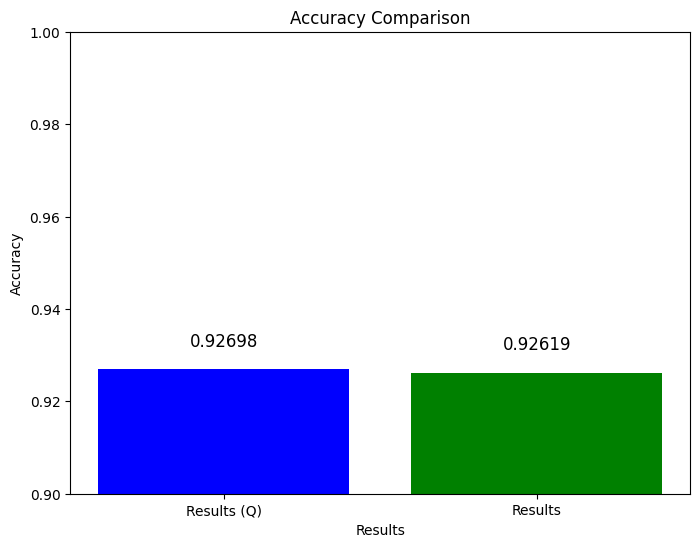

In [ ]:
import matplotlib.pyplot as plt

labels = ['Results (Q)', 'Results']
accuracy_values = [results_q['accuracy'], results_vanilla['accuracy']]

plt.figure(figsize=(8, 6))
plt.bar(labels, accuracy_values, color=['blue', 'green'])
plt.ylim(0.9, 1.0)  # Set the y-axis limits to ensure the entire range is visible

# Add labels and a title
plt.xlabel('Results')
plt.ylabel('Accuracy')
plt.title('Accuracy Comparison')

# Add text labels above the bars
for i in range(len(labels)):
    plt.text(i, accuracy_values[i] + 0.005, f'{accuracy_values[i]:.5f}', ha='center', fontsize=12)

# Show the plot
plt.show()

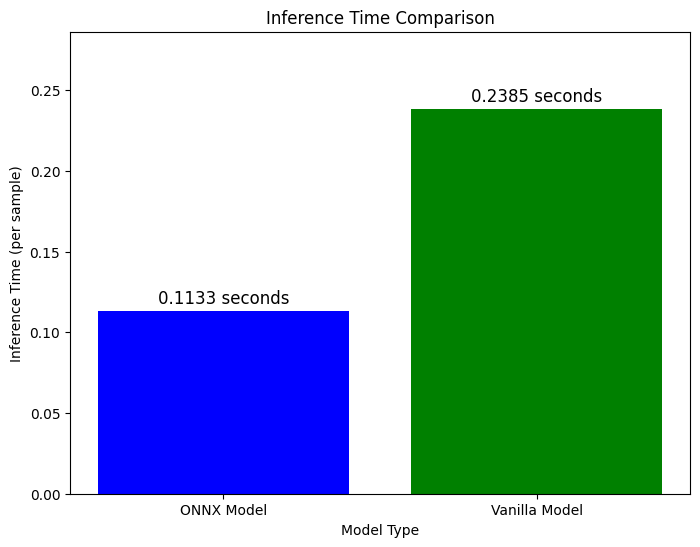

In [ ]:
import matplotlib.pyplot as plt

# Define the inference times
time_onnx = (t2_onnx - t1_onnx) / len(result_q)
time_vanilla = (t2 - t1) / len(result)

# Create a bar chart to visualize the inference times
labels = ['ONNX Model', 'Vanilla Model']
inference_times = [time_onnx, time_vanilla]

plt.figure(figsize=(8, 6))
plt.bar(labels, inference_times, color=['blue', 'green'])
plt.ylim(0, max(inference_times) * 1.2)  # Set the y-axis limits to ensure the entire range is visible

# Add labels and a title
plt.xlabel('Model Type')
plt.ylabel('Inference Time (per sample)')
plt.title('Average Inference Time Comparison (per sample)')

# Add text labels above the bars
for i in range(len(labels)):
    plt.text(i, inference_times[i] + max(inference_times) * 0.02, f'{inference_times[i]:.4f} seconds', ha='center', fontsize=12)

# Show the plot
plt.show()


In [ ]:
optimization_percentage = ((time_vanilla - time_onnx) / time_vanilla) * 100
print(f'Inference time optimized by {optimization_percentage:.3f}%')

In [ ]:
Project #3 - Deep Learning (Deadline, Diperpanjang hingga Senin 5 Februari 2024 Pukul 23.59 WIB)
Project #4 - Pytorch (Deadline HARI INI Jumat, 2 Februari 2024 Pukul 23.59 WIB)
Project #5 - Pipeline and Gradio (Deadline Rabu, 7 Februari 2024 Pukul 23.59 WIB)
Project #6 - Transfer Learning (Deadline Jumat, 16 Februari 2024 Pukul 23.59 WIB)
Post Test Course 4 - Model Usage dapat diakses di LMS
--> Kelas Saya --> Kelas Skill Academy Pro Live Lainnya
--> Course 4: Post Test Model Usage - Mastering AI Bootcamp Batch 2 (Deadline Senin, 5 Februari 2024 Pukul 23.59 WIB)

In [ ]:
Inference > waktu nya jadi berkurang, resource nya berkurang > performat tidak turun terlalu jauh